### This notebook fits raster image correlation (RICS) functions
Note that you need to have corr.tif from the sim_rics simulation (or from experimental data) loaded into your workspace.
We take the approach of simultaneously fitting the horizontal and vertical profiles.
Click here to open in google colab: http://colab.research.google.com/github/jayunruh/pysimfcs/blob/main/fit_rics.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
import os
if(not os.path.exists('pysimfcs_utils.py')):
    print('downloading pysimfcs libraries')
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/pysimfcs_utils.py
if(not os.path.exists('analysis_utils.py')):
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/analysis_utils.py
else:
    print('libraries already downloaded')

libraries already downloaded


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import analysis_utils as simutils
import pandas as pd
import scipy.optimize as so
import tifffile

In [3]:
#first read in the correlation images
corr=tifffile.imread('corr.tif')
corr.shape

(3, 64, 64)

In [4]:
#this creates the composite fitting parameters (horizontal and vertical profiles combined)
#we'll just analyze the channel1 correlation here
#for cross-correlation need to not skipg0
xvals,profiles=simutils.getricshalf(corr[0],skipg0=True)

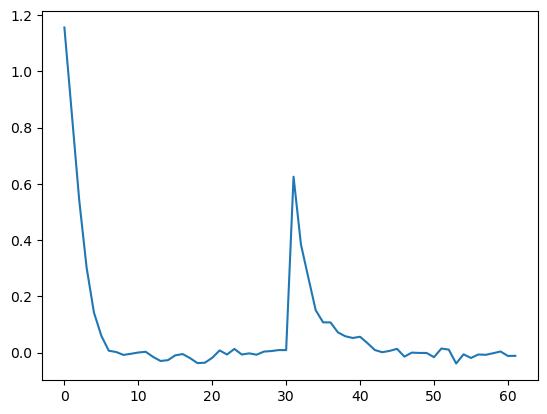

In [5]:
plt.plot(profiles)

In [6]:
#set up the metadata and the initial fitting parameters
simutils.ricspixeltime=1.0e-5 #in seconds
simutils.ricspixelsize=0.05 #in microns
simutils.ricslinetime=0.00064 #in seconds
#parameters are baseline,w0,zratio,G01,D1,...
gparams=[0.0,0.17,5.0,1.0,10.0]
llims=[gparams[0]-0.5,0.1,4.9999,gparams[3]/3.0,gparams[4]/3.0]
ulims=[gparams[0]+0.5,0.3,5.0001,gparams[3]*3.0,gparams[4]*3.0]

In [7]:
fparams,fcov=so.curve_fit(simutils.ricsfunc,xvals,profiles,
             p0=gparams,bounds=(llims,ulims),method='trf')

#the standard error methods utilizes the square root of the diagonal of the covariance matrix
ferrs=np.sqrt(np.diag(fcov))
#now get the fit from the optimized parameters
fit=simutils.ricsfunc(xvals,*fparams)
#and get the chi squared value
rchi2=((profiles-fit)**2).sum()/(len(profiles)-len(gparams))

In [9]:
print('Here are the best fit parameters:')
print(fparams)
print('Here are the errors (based on covariance):')
print(ferrs)

Here are the best fit parameters:
[-0.00986089  0.16566438  4.9999      1.28266306  9.67537715]
Here are the errors (based on covariance):
[0.00228544 0.00202439 1.98992509 0.01538617 0.56253127]


In [10]:
#now separate the horizontal and vertical profiles for the data and the fit
hfit,vfit,fitxvals=simutils.getricsfull(xvals,fit)
hprof,vprof,xprof=simutils.getricsfull(xvals,profiles)

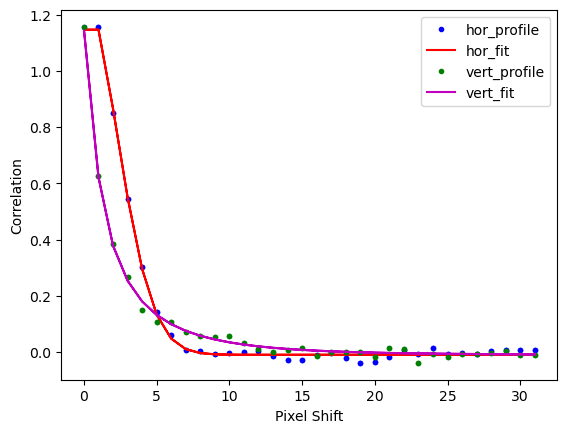

In [11]:
plt.plot(xprof,hprof,'b.')
plt.plot(xprof,hfit,'r-')
plt.plot(xprof,vprof,'g.')
plt.plot(xprof,vfit,'m-')
plt.legend(['hor_profile','hor_fit','vert_profile','vert_fit'])
plt.xlabel('Pixel Shift')
plt.ylabel('Correlation')
plt.show()